In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona

import shapely
from shapely.validation import make_valid


In [2]:
from general_functions import *

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
#define relative paths
waterschap = 'Rijnland'
path_Rijnland = '..\..\Data_preprocessed\Waterschappen\Rijnland\DataRijnland\DataRijnland.gpkg'
output_gpkg_path = "../../Data_postprocessed/Waterschappen/Rijnland"


In [5]:
Rijnland = read_gpkg_layers(gpkg_path = path_Rijnland, 
                        variables = ['stuw', 
                                     'gemaal', 
                                     'afsluitmiddel',
                                     'duikersifonhevel',
                                     'hydroobject',
                                     'peilgebiedvigerend',
                                     'peilgebiedpraktijk',
                                     'peilafwijkinggebied',
                                     'streefpeil']) 
                                     

In [6]:
Rijnland['gemaal'].functiegemaal.unique()

array(['Opmaling', 'Afvoergemaal', 'Onderbemaling', 'Doorspoelgemaal',
       'Aanvoergemaal', None, 'Overig', 'Noodpomp'], dtype=object)

In [7]:
#determine aanvoer en afvoer gemalen
Rijnland['gemaal']['func_aanvoer'], Rijnland['gemaal']['func_afvoer'], Rijnland['gemaal']['func_circulatie']  = False, False, False #default is False
Rijnland['gemaal']['functiegemaal'] = Rijnland['gemaal']['functiegemaal'].astype(str) 

Rijnland['gemaal'].loc[Rijnland['gemaal'].functiegemaal.str.contains('Afvoergemaal|Onderbemaling|Overig'), 'func_afvoer'] = True
Rijnland['gemaal'].loc[Rijnland['gemaal'].functiegemaal.str.contains('Opmaling|Aanvoergemaal'), 'func_aanvoer'] = True
Rijnland['gemaal'].loc[Rijnland['gemaal'].functiegemaal.str.contains('Doorspoelgemaal|Noodpomp'), 'func_circulatie'] = True
Rijnland['gemaal'].loc[(Rijnland['gemaal'].func_afvoer == False) &
                       (Rijnland['gemaal'].func_aanvoer == False) &
                       (Rijnland['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [8]:
path_Rijnland_nalevering = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Rijnland\20240402_gegevensRL_nalevering.gdb"

Rijnland_nalevering = read_gpkg_layers(gpkg_path = path_Rijnland_nalevering, 
                        variables = ['boezemvak', 
                                     'Inlaat', 
                                     'Peilgebiedenpraktijk_aggregatie_RL']) 

# Rijnland

<AxesSubplot:>

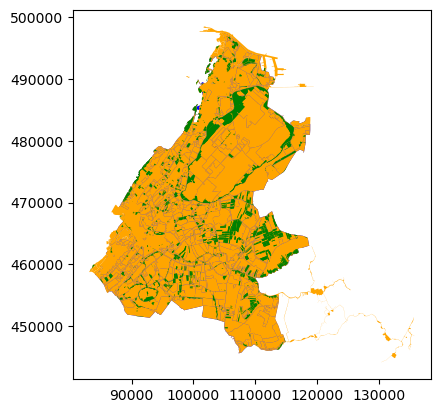

In [9]:
fig, ax = plt.subplots()
Rijnland['peilgebiedvigerend'].plot(ax=ax, color='blue')
Rijnland['peilgebiedpraktijk'].plot(ax=ax, color='orange')
Rijnland['peilafwijkinggebied'].plot(ax=ax, color='green')

In [10]:
Rijnland['stuw'] = Rijnland['stuw'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['gemaal'] = Rijnland['gemaal'][['code', 'nen3610id', 'globalid', 'geometry', 'func_aanvoer', 'func_afvoer', 'func_circulatie']]
Rijnland['afsluitmiddel'] = Rijnland['afsluitmiddel'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['hydroobject'] = Rijnland['hydroobject'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['duikersifonhevel'] = Rijnland['duikersifonhevel'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebiedpraktijk'] = Rijnland['peilgebiedpraktijk'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilafwijkinggebied'] = Rijnland['peilafwijkinggebied'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebiedvigerend'] = Rijnland['peilgebiedvigerend'][['code', 'nen3610id', 'globalid', 'geometry']]


In [11]:
#fix geometries
Rijnland['peilgebiedvigerend']['geometry'] = Rijnland['peilgebiedvigerend'].buffer(distance = 0)
Rijnland['peilgebiedpraktijk']['geometry'] = Rijnland['peilgebiedpraktijk'].buffer(distance = 0)
Rijnland['peilafwijkinggebied']['geometry'] = Rijnland['peilafwijkinggebied'].buffer(distance = 0)

C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


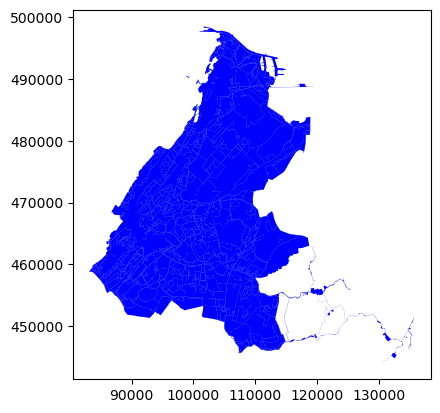

In [12]:
# peilgebied = burn_in_peilgebieden(base_layer = Rijnland['peilgebiedpraktijk'], 
#                                   overlay_layer = Rijnland['peilafwijkinggebied'],
#                                   plot = True)
# Rijnland['peilgebied'] = gpd.GeoDataFrame(peilgebied)

peilgebied = burn_in_peilgebieden(base_layer = Rijnland['peilgebiedvigerend'], 
                                  overlay_layer = Rijnland['peilgebiedpraktijk'],
                                  plot = True)


In [13]:
#Add aggregation areas
peilgebied = peilgebied.loc[peilgebied.code!='RIJNLANDSBOEZEM'] #REMOVE the boezem, as it needs to be split based on the second data delivery

Rijnland['aggregation_area'] = Rijnland_nalevering['Peilgebiedenpraktijk_aggregatie_RL']
boezem = Rijnland['aggregation_area'][(Rijnland['aggregation_area']['CODE_AFW'].str.startswith('NL13_')) |
                                       Rijnland['aggregation_area']['RL_aggregatie_id'].str.contains('ouwe')] #only select the boezem to add to the peilgebieden
Rijnland['aggregation_area'].RL_aggregatie_id.fillna(Rijnland['aggregation_area']['CODE_AFW'], inplace=True)
Rijnland['aggregation_area'] = Rijnland['aggregation_area'].dissolve(by='RL_aggregatie_id', as_index=False)#.plot()
Rijnland['aggregation_area'] = Rijnland['aggregation_area'][['code', 'nen3610id', 'CODE_AFW', 'globalid', 'geometry']]

Rijnland['aggregation_area']['code'] = Rijnland['aggregation_area']['code'].astype(str) + '_dummy_id_' + Rijnland['aggregation_area'].index.astype(str)

pg_sp_Gouwe = Rijnland['aggregation_area'].loc[Rijnland['aggregation_area'].CODE_AFW == 'Gouwe']
pg_sp_Gouwe['naam'] = 'Gouwe'
boezem = gpd.GeoDataFrame(pd.concat([boezem, pg_sp_Gouwe]), geometry = 'geometry') #add the Gouwe to the boezem

C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
peilgebied = gpd.GeoDataFrame(peilgebied)
peilgebied = peilgebied[peilgebied.geometry.type.isin(['Polygon', 'MultiPolygon'])] #only select polygons

Rijnland['peilgebied'] = gpd.GeoDataFrame(peilgebied)

In [15]:
Rijnland['streefpeil'].peilgebiedpraktijkid.fillna(value=Rijnland['streefpeil']['peilgebiedvigerendid'], inplace=True)
# Rijnland['streefpeil'].drop_duplicates(subset=['peilgebiedpraktijkid'], inplace=True)

In [16]:
#get rid of irrelevant streefpeilen, which otherwise results in too many overlapped peilgebieden
filter_condition = Rijnland['streefpeil']['soortstreefpeil'].isin(['omer', 'ondergrens']) #'omer' for all rows where something of zomer, Zomer, dynamische zomer, etc, is used
kept_rows = Rijnland['streefpeil'][filter_condition]

other_rows = Rijnland['streefpeil'][~filter_condition].drop_duplicates(subset=['peilgebiedpraktijkid'])
Rijnland['streefpeil'] = pd.concat([kept_rows, other_rows])

In [17]:
# Rijnland['streefpeil'].peilafwijkinggebiedid.fillna(value=Rijnland['streefpeil']['peilgebiedpraktijkid'], inplace=True)
# Rijnland['streefpeil'].peilgebiedpraktijkid.fillna(value=Rijnland['streefpeil']['peilgebiedvigerendid'], inplace=True)

pg_sp = pd.merge(left = peilgebied,
                      right = Rijnland['streefpeil'],
                      left_on = 'globalid',
                      right_on = 'peilgebiedpraktijkid',
                      suffixes = ('', '_streefpeil'))

pg_sp['geometry'] = gpd.GeoDataFrame(geometry = pg_sp['geometry']).reset_index(drop=True)
# pg_sp = pg_sp.explode('geometry',ignore_index=True)

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_22236\371328050.py:10: UserWarning: Geometry column does not contain geometry.
  pg_sp['geometry'] = gpd.GeoDataFrame(geometry = pg_sp['geometry']).reset_index(drop=True)


In [18]:
#there are duplicate codes, nen3610ids and globalids due to the exploded function. Rename these.
# pg_sp['nen3610id'] = 'dummy_nen3610id_peilgebied_' + pg_sp.index.astype(str)
# pg_sp['code'] = 'dummy_code_peilgebied_' + pg_sp.index.astype(str)
pg_sp['globalid'] = 'dummy_globalid_peilgebied_' + pg_sp.index.astype(str)

#add the boezem with the peilgebied
boezem['globalid'] = 'dummy_globalid_boezem_' + boezem.index.astype(str)
boezem['waterhoogte'] = 0.61
pg_sp = pd.concat([pg_sp, boezem])

Rijnland['peilgebied'] = pg_sp
Rijnland['peilgebied'] = Rijnland['peilgebied'][['code', 'nen3610id', 'globalid', 'geometry']]
Rijnland['peilgebied'] = gpd.GeoDataFrame(Rijnland['peilgebied'], geometry = 'geometry')
Rijnland['peilgebied'] = Rijnland['peilgebied'].set_crs('EPSG:28992')

In [19]:
streefpeil = pg_sp[['waterhoogte', 'globalid']]

streefpeil['geometry'] = np.nan
streefpeil = gpd.GeoDataFrame(streefpeil)
Rijnland['streefpeil'] = streefpeil

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_22236\1567509723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streefpeil['geometry'] = np.nan


In [20]:
#delete irrelvant data
variables = ['peilgebiedpraktijk', 'peilgebiedvigerend', 'peilafwijkinggebied']

for variable in variables:
    if str(variable) in Rijnland:
        del Rijnland[variable]

In [21]:
#Add the duikersifonhevels to the hydroobjecten
Rijnland['hydroobject'] = pd.concat([Rijnland['hydroobject'], Rijnland['duikersifonhevel']])
Rijnland['hydroobject'] = gpd.GeoDataFrame(Rijnland['hydroobject'], geometry = 'geometry')

In [22]:
bzm = Rijnland['peilgebied'].loc[Rijnland['peilgebied'].code.str.contains('BOEZEM')].reset_index(drop=True)
all_others = Rijnland['peilgebied'].loc[~Rijnland['peilgebied'].code.str.contains('BOEZEM')].reset_index(drop=True)

<AxesSubplot:>

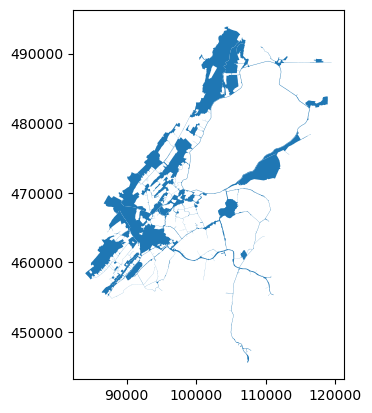

In [23]:
bzm.plot()

In [24]:
# bzm.to_file('bzm_Rijnland.shp')
# all_others.to_file('all_others_Rijnland.shp')

In [25]:
bzm = bzm.set_crs(crs='EPSG:28992').reset_index(drop=True)
all_others = all_others.set_crs(crs='EPSG:28992').reset_index(drop=True)

bzm.geometry = bzm.buffer(1)
bzm = bzm.dropna(subset='geometry')
bzm.geometry = bzm.symmetric_difference(all_others)
bzm = bzm.dropna(subset='geometry')

total = pd.concat([bzm, all_others])
total = gpd.GeoDataFrame(total, geometry='geometry').reset_index(drop=True)

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_22236\761390022.py:6: UserWarning: The indices of the two GeoSeries are different.
  bzm.geometry = bzm.symmetric_difference(all_others)


In [26]:
from shapely.geometry import Polygon, MultiPolygon, shape, Point
from shapely.ops import unary_union,cascaded_union 

def convert_to_polygon(line):
    if line.is_ring:  # Checks if the LineString is closed
        return Polygon(line)
    else:
        return line  # Returns the line string as is if it's not closed
    
total = total.explode(ignore_index=True)
total = total[total.geometry.type.isin(['Polygon', 'MultiPolygon'])] #also only select polygons
    
# total = total.explode(ignore_index=True)
total = total[total.geometry.type.isin(['Polygon', 'MultiPolygon'])] #also only select polygons


total['area'] = total.area
dissolved = total.dissolve()
exterior = gpd.GeoDataFrame(geometry=dissolved['geometry'].boundary).to_crs(crs='EPSG:28992')
total = total.to_crs(crs='EPSG:28992')
exterior = exterior.explode().reset_index(drop=True)
exterior['geometry'] = exterior['geometry'].apply(convert_to_polygon)
exterior['area'] = exterior.area
exterior = exterior.sort_values(by='area', ascending=False).reset_index(drop=True)

#get rid of some exteriors which should not be filled in
exterior.loc[exterior.area != 67444.410779918616754]
exterior = exterior.iloc[8::]
exterior = exterior.reset_index(drop=True)

exterior = exterior.reset_index(drop=True)

# new_gdf = gpd.GeoDataFrame(columns=total.columns())

for i in range(len(exterior)):
# for i in range(10):

    buffered_peilgebied = total.buffer(0.)

    exterior_sample = exterior.iloc[i:i+1] #just pick a single sample
    exterior_sample.geometry = exterior_sample.buffer(0.0001) #let op! hierdoor komt er alsnog een kleine overlap. Maar anders werkt de code even niet, en vanwege tijdgebrek kan dit nu niet worden opgelost. In het bepalen van de crossings wordt hier echter mee omgegaan.
    
    intersects_mask = buffered_peilgebied.intersects(exterior_sample.iloc[0].geometry)
    intersecting_polygons = total[intersects_mask].sort_values(by='area', ascending=False)

    if len(intersecting_polygons) > 0:
        # print(i)
        # polygon_to_dissolve = intersecting_polygons.iloc[0:1]#.geometry.unary_union  
        # sample_geometry = exterior_sample.geometry#.unary_union
        intersecting_polygons = gpd.GeoDataFrame(intersecting_polygons.iloc[0:1], geometry = 'geometry')
        
        # dissolved_polygon =   # dissolve/union them
        all_geometries = list(intersecting_polygons.geometry) + list(exterior_sample.geometry)

        # Use unary_union to dissolve all polygons in the list
        dissolved_polygon = unary_union(all_geometries)
        
        original_index = intersecting_polygons.index[0]

        # Ensure it's a single geometry object.
        # print(len(total.loc[total.index == original_index, 'geometry']))
        # print(len(dissolved_polygon))
        total.loc[total.index == original_index, 'geometry'] = dissolved_polygon#['geometry']
        # new_gdf = pd.concat([new_gdf, dissolved_polygon])
    else:
        print('No intersection found for iteration ', i)

C:\Users\Bruijns\AppData\Local\Temp\ipykernel_22236\2749980879.py:21: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exterior = exterior.explode().reset_index(drop=True)
C:\Users\Bruijns\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [27]:
exterior.to_file('exterior_Rijnland.shp')

In [27]:
Rijnland['peilgebied'] = total


In [28]:
Rijnland['streefpeil'].waterhoogte = Rijnland['streefpeil'].waterhoogte.round(2)

In [29]:
#reload the boezem. It has been buffered and then clipped on the other peilgebieden, to make sure all gaps are filled


In [30]:
Rijnland['peilgebied']

,code,nen3610id,globalid,geometry,area
0,PBS_RIJNLANDSBOEZEM - Aanvulling PBS-00363,NL.WBHCODE.13.Peilgebiedvigerend.7682,dummy_globalid_peilgebied_6,"POLYGON ((100416.597 479665.902, 100416.596 47...",8.872630e+00
1,PBS_RIJNLANDSBOEZEM - Aanvulling PBS-00363,NL.WBHCODE.13.Peilgebiedvigerend.7682,dummy_globalid_peilgebied_6,"POLYGON ((100265.398 479731.704, 100265.394 47...",3.606838e+02
2,PBS_RIJNLANDSBOEZEM - Aanvulling PBS-00363,NL.WBHCODE.13.Peilgebiedvigerend.7682,dummy_globalid_peilgebied_6,"POLYGON ((100256.025 479865.950, 100264.082 47...",1.081529e+02
3,PBS_RIJNLANDSBOEZEM - Aanvulling PBS-00363,NL.WBHCODE.13.Peilgebiedvigerend.7682,dummy_globalid_peilgebied_6,"POLYGON ((100053.575 478917.651, 100053.648 47...",8.758138e+00
4,PBS_RIJNLANDSBOEZEM - Aanvulling PBS-00363,NL.WBHCODE.13.Peilgebiedvigerend.7682,dummy_globalid_peilgebied_6,"POLYGON ((116604.646 464224.245, 116607.555 46...",7.272443e-05
...,...,...,...,...,...
8804,WW-09K,NL.WBHCODE.13.Peilgebiedpraktijk.1707,dummy_globalid_peilgebied_1357,"POLYGON ((97104.931 460639.993, 97105.856 4606...",1.404138e+06
8805,RL-010-3.1,NL.WBHCODE.13.Peilgebiedpraktijk.1708,dummy_globalid_peilgebied_1358,"POLYGON ((94163.596 465298.477, 94165.318 4652...",4.345614e+05
8806,WW-09A,NL.WBHCODE.13.Peilgebiedpraktijk.1709,dummy_globalid_peilgebied_1359,"POLYGON ((98639.002 459871.114, 98639.002 4598...",2.268386e+06
8807,WW-25AH,NL.WBHCODE.13.Peilgebiedpraktijk.1998,dummy_globalid_peilgebied_1360,"POLYGON ((101455.305 456467.297, 101403.881 45...",3.520037e+06


In [31]:
combined = pd.merge(left = Rijnland['peilgebied'],
                    right = Rijnland['streefpeil'],
                    on = 'globalid',
                    how = 'left',
                    suffixes = ('', '_sp')).reset_index(drop=True)

combined = gpd.GeoDataFrame(combined, geometry='geometry')
combined.code = combined.code + '_' + combined.index.astype(str)
combined.globalid = combined.globalid + '_' + combined.index.astype(str)

Rijnland['peilgebied'] = combined[['code', 'nen3610id', 'globalid', 'geometry']]

Rijnland['streefpeil']['geometry'] = None
Rijnland['streefpeil'] = gpd.GeoDataFrame(combined[['waterhoogte', 'globalid', 'geometry']], geometry='geometry')

In [32]:
Rijnland['hydroobject'].code = Rijnland['hydroobject'].code + '_' + Rijnland['hydroobject'].index.astype(str) 
# Rijnland['peilgebied'].code = Rijnland['peilgebied'].code + '_' + Rijnland['peilgebied'].index.astype(str) 
# Rijnland['peilgebied'].globalid = Rijnland['peilgebied'].globalid + '_' + Rijnland['peilgebied'].index.astype(str) 

In [33]:
Rijnland['hydroobject']

,code,nen3610id,globalid,geometry
0,174-058-00080-04_0,NL.WBHCODE.13.Hydroobject.789716,{FEB49A57-8C9D-48CB-A895-8777D12CB9D9},"LINESTRING (97388.109 468171.303, 97385.257 46..."
1,077-058-00326-01_1,NL.WBHCODE.13.Hydroobject.49229,{C0DC5E47-14DC-41B9-ADFF-D0ED9FA2DC5B},"LINESTRING (103968.757 456387.807, 103975.602 ..."
2,077-058-00336-02_2,NL.WBHCODE.13.Hydroobject.49249,{9D984A0E-AB4E-4EDA-B199-B9E567CBF455},"LINESTRING (104940.751 455095.857, 104940.812 ..."
3,077-058-00342-02_3,NL.WBHCODE.13.Hydroobject.49263,{090E19AD-C548-4AE9-AEBA-50F03D10A375},"LINESTRING (103817.911 456698.921, 103818.571 ..."
4,077-058-00342-04_4,NL.WBHCODE.13.Hydroobject.49265,{9FA9FC47-B2B8-4D75-9F9E-0953A337E3F6},"LINESTRING (103893.043 456453.097, 103893.701 ..."
...,...,...,...,...
35957,107-033-00333_35957,NL.WBHCODE.13.Duikersifonhevel.476989,{34F1AB6A-C46D-446E-9486-CD57207C726A},"LINESTRING (91159.591 469326.780, 91148.178 46..."
35958,078-033-00082_35958,NL.WBHCODE.13.Duikersifonhevel.360366,{DEFA63AE-0702-4963-9BAF-213F07945CFF},"LINESTRING (99934.878 463132.555, 99936.654 46..."
35959,016-033-00187_35959,NL.WBHCODE.13.Duikersifonhevel.476991,{9E75C497-43F4-449D-A6A9-AADF1466C3E8},"LINESTRING (96179.051 465624.809, 96180.499 46..."
35960,162-033-00066_35960,NL.WBHCODE.13.Duikersifonhevel.176321,{48A5C8C9-C806-4F2E-B409-5E9A3D56CEF4},"LINESTRING (99593.400 468415.310, 99587.290 46..."


### Check for the correct keys and columns

In [34]:
show_layers_and_columns(waterschap = Rijnland)

stuw
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'nen3610id' 'globalid' 'geometry' 'func_aanvoer' 'func_afvoer'
 'func_circulatie']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

aggregation_area
['code' 'nen3610id' 'CODE_AFW' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'nen3610id' 'globalid' 'geometry

### Store data

In [35]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = Rijnland, 
           output_gpkg_path = output_gpkg_path + '/Rijnland')
